# 风电发力Baseline

相关库

In [2]:
import numpy as np
import pandas as pd
import optuna
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt 
import matplotlib.font_manager as fm
import json

In [3]:
try:
    font_list = [f.name for f in fm.fontManager.ttflist]
    if 'WenQuanYi Zen Hei' in font_list:
        plt.rcParams['font.sans-serif'] = ['WenQuanYi Zen Hei']
    else:
        raise Exception("WenQuanYi Zen Hei font not found")
except Exception as e:
    print("无法加载 WenQuanYi Zen Hei 字体，请检查该字体是否安装，错误信息：", e)
    plt.rcParams['font.sans-serif'] = ['Microsoft YaHei', 'DejaVu Sans']

plt.rcParams['axes.unicode_minus'] = False

定义函数及相关常量

In [4]:
# cities = [
#     '呼和浩特',
#     '包头',
#     '乌海',
#     '鄂尔多斯+薛家湾',
#     '巴彦淖尔',
#     '乌兰察布',
#     '锡林郭勒',
#     '阿拉善盟']

cities = [
    '呼和浩特',
    '阿拉善盟']

In [5]:
def compute_daily_metrics(df):
    # 直接使用正余弦信息，不再转换为角度
    features = ['t2m', 'ws10m', 'wd10m_sin', 'wd10m_cos', 'sp']
    weather_ts = df[features].values  # shape (T, len(features))
    wind_series = df['wind_output'].values
    time_idx = np.arange(len(wind_series))
    if np.var(time_idx) == 0:
        slope = 0
    else:
        slope = np.cov(time_idx, wind_series)[0, 1] / np.var(time_idx)
    return weather_ts, slope, wind_series

def compute_similarity(day1, day2, params, daily_metrics):
    # 获取天气时间序列
    weather1 = daily_metrics[day1]['weather_ts']
    weather2 = daily_metrics[day2]['weather_ts']
    # 截取最小长度，确保数组形状一致
    min_length = min(weather1.shape[0], weather2.shape[0])
    weather1 = weather1[:min_length, :]
    weather2 = weather2[:min_length, :]
    weather_dist = np.sqrt(np.sum((weather1 - weather2)**2, axis=0))
    sim_feature = - np.dot(params['w_feature'], weather_dist)
    
    # 计算斜率差异
    slope_diff = np.abs(daily_metrics[day1]['slope'] - daily_metrics[day2]['slope'])
    sim_slope = - params['w_slope'] * slope_diff
    
    # 处理风功率序列，确保相同长度
    wind1 = daily_metrics[day1]['wind_series']
    wind2 = daily_metrics[day2]['wind_series']
    min_wind_length = min(len(wind1), len(wind2))
    wind1 = wind1[:min_wind_length]
    wind2 = wind2[:min_wind_length]
    euclid_dist = np.linalg.norm(wind1 - wind2)
    sim_euclid = - params['w_euclid'] * euclid_dist
    
    # 计算皮尔逊相关系数
    try:
        corr, _ = pearsonr(wind1, wind2)
    except Exception:
        corr = 0
    sim_pearson = params['w_pearson'] * corr
    
    total_similarity = sim_feature + sim_slope + sim_euclid + sim_pearson
    return total_similarity

def objective(trial, daily_dates, daily_metrics):
    w_feature = [
        trial.suggest_float('w_feature_0', 0, 1),
        trial.suggest_float('w_feature_1', 0, 1),
        trial.suggest_float('w_feature_2', 0, 1),
        trial.suggest_float('w_feature_3', 0, 1),
        trial.suggest_float('w_feature_4', 0, 1)
    ]
    w_slope = trial.suggest_float('w_slope', 0, 1)
    w_euclid = trial.suggest_float('w_euclid', 0, 1)
    w_pearson = trial.suggest_float('w_pearson', 0, 1)
    
    params = {
        'w_feature': np.array(w_feature),
        'w_slope': w_slope,
        'w_euclid': w_euclid,
        'w_pearson': w_pearson
    }
    
    errors = []
    for val_day in daily_dates:
        similarities = {}
        for candidate_day in daily_dates:
            if candidate_day == val_day:
                continue
            sim = compute_similarity(val_day, candidate_day, params, daily_metrics)
            similarities[candidate_day] = sim
        if len(similarities) == 0:
            continue
        best_day = max(similarities, key=similarities.get)
        forecast = daily_metrics[best_day]['wind_series']
        actual = daily_metrics[val_day]['wind_series']
        if len(forecast) != len(actual):
            continue
        rmse = np.sqrt(mean_squared_error(actual, forecast))
        errors.append(rmse)
    if len(errors) == 0:
        return 0.0
    return np.mean(errors)

def get_similar_day(target_day, params, daily_dates, daily_metrics):
    similarities = {}
    for candidate_day in daily_dates:
        if candidate_day == target_day:
            continue
        sim = compute_similarity(target_day, candidate_day, params, daily_metrics)
        similarities[candidate_day] = sim
    best_day = max(similarities, key=similarities.get)
    return best_day

def normalize_data(merged_df):
    norm_models = {}

    # 温度 t2m: Z-score 标准化（原地修改）
    mean_t2m = merged_df['t2m'].mean()
    std_t2m = merged_df['t2m'].std()
    merged_df['t2m'] = merged_df['t2m'].apply(lambda x: (x - mean_t2m) / std_t2m)
    norm_models['t2m'] = {'method': 'z-score', 'mean': float(mean_t2m), 'std': float(std_t2m)}

    # 风速 ws10m: Z-score 标准化（原地修改）
    mean_ws10m = merged_df['ws10m'].mean()
    std_ws10m = merged_df['ws10m'].std()
    merged_df['ws10m'] = merged_df['ws10m'].apply(lambda x: (x - mean_ws10m) / std_ws10m)
    norm_models['ws10m'] = {'method': 'z-score', 'mean': float(mean_ws10m), 'std': float(std_ws10m)}

    # 气压 sp: Z-score 标准化（原地修改）
    mean_sp = merged_df['sp'].mean()
    std_sp = merged_df['sp'].std()
    merged_df['sp'] = merged_df['sp'].apply(lambda x: (x - mean_sp) / std_sp)
    norm_models['sp'] = {'method': 'z-score', 'mean': float(mean_sp), 'std': float(std_sp)}

    # 风向 wd10m: 采用正余弦转换
    # 扩展为两个新列，再删除原始 wd10m（后续在反归一化时恢复原始角度）
    merged_df['wd10m_sin'] = np.sin(merged_df['wd10m'] * np.pi/180)
    merged_df['wd10m_cos'] = np.cos(merged_df['wd10m'] * np.pi/180)
    merged_df.drop(columns=['wd10m'], inplace=True)
    norm_models['wd10m'] = {'method': 'sin-cos'}

    # 风力发电输出 wind_output: Min-Max 归一化（原地修改）
    min_wind = merged_df['wind_output'].min()
    max_wind = merged_df['wind_output'].max()
    merged_df['wind_output'] = merged_df['wind_output'].apply(lambda x: (x - min_wind) / (max_wind - min_wind))
    norm_models['wind_output'] = {'method': 'min-max', 'min': float(min_wind), 'max': float(max_wind)}

    # 保存归一化模型参数到 json 文件
    with open('../output/wind_data_normalization_models.json', 'w') as f:
        json.dump(norm_models, f, indent=4)

    print("归一化预览（原地修改）：")
    print(merged_df.head(1))
    print("归一化模型已保存到 ../output/wind_data_normalization_models.json")
    return merged_df

def unnormalize_data(normalized_df):
    # 从文件中加载归一化模型参数
    with open('../output/wind_data_normalization_models.json', 'r') as f:
        norm_models = json.load(f)

    # 反归一化风力发电输出 wind_output（Min-Max）
    min_wind = norm_models['wind_output']['min']
    max_wind = norm_models['wind_output']['max']
    normalized_df['wind_output'] = normalized_df['wind_output'].apply(
        lambda x: x * (max_wind - min_wind) + min_wind
    )

    return normalized_df
    
def save_weights(best_params, city):
    # 将 numpy 数组转换为 list（如果存在 numpy 数组）
    best_params_to_save = {k: v.tolist() if hasattr(v, 'tolist') else v for k, v in best_params.items()}

    with open('../output/wind_output_baseline_best_params_for_' + city + '.json', 'w') as f:
        json.dump(best_params_to_save, f, indent=4)

    print("best_params has been saved.")

def load_weights(city):
    with open('../output/wind_output_baseline_best_params_for_' + city + '.json', 'r') as f:
        loaded_params = json.load(f)

    best_params = {
        'w_feature': np.array(loaded_params['w_feature']),
        'w_slope': loaded_params['w_slope'],
        'w_euclid': loaded_params['w_euclid'],
        'w_pearson': loaded_params['w_pearson']
    }

    print(f"loaded best_params for {city}: {best_params}")
    return best_params

遍历搜索不同城市模型的权重

In [6]:
def get_data_for_city(city):
    print('inside get_data_for_city func\n\n')
    weather_df = pd.read_csv('../data/history_weather_data_for_' + city + '.csv', sep=',', dayfirst=False)
    weather_df['datetime'] = pd.to_datetime(weather_df['datetime'])
    weather_df.set_index('datetime', inplace=True)
    weather_df.drop(columns=['city'], inplace=True)

    output_df = pd.read_csv('../data/history_wind_power_output_for_all.csv', sep=',', dayfirst=True)
    print(output_df.head(1))
    output_df = output_df[output_df['city_name'] == city]
    print(output_df.head(1))
    output_df.drop(columns=['type', 'city_name'], inplace=True)
    print(output_df.head(1))
    output_df['date_time'] = pd.to_datetime(output_df['date_time'], dayfirst=True)
    output_df.set_index('date_time', inplace=True)
    output_df.rename(columns={'date_time': 'datetime', 'value': 'wind_output'}, inplace=True)

    output_df = output_df.resample('H', closed='right', label='right').mean()

    merged_df = pd.merge(weather_df, output_df, left_index=True, right_index=True, how='inner')
    merged_df = merged_df.dropna()
    # 强制将索引转换为 DatetimeIndex
    merged_df.index = pd.to_datetime(merged_df.index)
    merged_df['date'] = merged_df.index.date
    merged_df = merged_df.groupby('date').filter(lambda group: len(group) == 24)
    print(merged_df.columns)
    print(merged_df.head(1))
    normalized_df = normalize_data(merged_df)

    return normalized_df

In [ ]:
def get_daily_data(normalized_df):
    daily_metrics = {}
    for date, group in normalized_df.groupby('date'):
        weather_ts, slope, wind_series = compute_daily_metrics(group)
        daily_metrics[date] = {'weather_ts': weather_ts, 'slope': slope, 'wind_series': wind_series}
    daily_dates = sorted(daily_metrics.keys())
    print("参与优化的日期数量:", len(daily_dates))

    return daily_dates, daily_metrics

def search_best_weights(normalized_df, n_trials):
    daily_dates, daily_metrics = get_daily_data(normalized_df)

    # 优化过程：通过 lambda 包装 objective 传入 daily_dates 和 daily_metrics
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, daily_dates, daily_metrics), n_trials)
    print("Best trial:")
    print(study.best_trial.values)
    print(study.best_trial.params)

    best_params = {
        'w_feature': np.array([
            study.best_trial.params['w_feature_0'],
            study.best_trial.params['w_feature_1'],
            study.best_trial.params['w_feature_2'],
            study.best_trial.params['w_feature_3'],
            study.best_trial.params['w_feature_4']
        ]),
        'w_slope': study.best_trial.params['w_slope'],
        'w_euclid': study.best_trial.params['w_euclid'],
        'w_pearson': study.best_trial.params['w_pearson']
    }

    return best_params

In [ ]:
# 测试集：预测单城市
def predict_for_test_return(city, day_index):
    """
    对单个城市的指定测试日做预测，返回：
      actual_unnorm: 实际结果 (1D numpy 数组)
      forecast: 预测结果 (1D numpy 数组)
      metrics: 字典，包含 RMSE, MAE, MAPE
    """
    print(f'cur city: {city}')
    normalized_df = get_data_for_city(city)
    print(normalized_df.head(1))
    daily_dates, daily_metrics = get_daily_data(normalized_df)
    print(f'daily_dates len: {len(daily_dates)}')
    # 加载该城市训练好的权重参数
    best_params = load_weights(city)
    target_day = daily_dates[day_index]
    similar_day = get_similar_day(target_day, best_params, daily_dates, daily_metrics)
    print(f"[{city}] Target day: {target_day}; Most similar day: {similar_day}")
    
    # 使用最相似日的风电序列作为预测（归一化状态下）
    forecast_norm = daily_metrics[similar_day]['wind_series']
    forecast_df = pd.DataFrame({'wind_output': forecast_norm})
    forecast_df = unnormalize_data(forecast_df)
    forecast = forecast_df['wind_output'].values
    
    actual = daily_metrics[target_day]['wind_series']
    actual_df = pd.DataFrame({'wind_output': actual})
    actual_df = unnormalize_data(actual_df)
    actual_unnorm = actual_df['wind_output'].values
    
    # 确保长度一致
    min_len = min(len(actual_unnorm), len(forecast))
    actual_unnorm = actual_unnorm[:min_len]
    forecast = forecast[:min_len]
    
    rmse = np.sqrt(mean_squared_error(actual_unnorm, forecast))
    mae = mean_absolute_error(actual_unnorm, forecast)
    actual_safe = np.where(actual_unnorm==0, 1e-6, actual_unnorm)
    mape = np.mean(np.abs((actual_unnorm - forecast) / actual_safe)) * 100
    metrics = {'RMSE': rmse, 'MAE': mae, 'MAPE': mape}
    
    # 绘制单城市预测曲线
    plt.figure(figsize=(10,6))
    plt.plot(actual_unnorm, label='Actual', marker='o')
    plt.plot(forecast, label='Forecast', marker='x', linestyle='--')
    plt.legend()
    plt.title(f"{city} {target_day} Forecast Results")
    plt.xlabel("Hour")
    plt.ylabel("Wind Power Output")
    plt.show()
    
    print(f"[{city}] RMSE: {rmse:.3f}, MAE: {mae:.3f}, MAPE: {mape:.2f}%")
    return actual_unnorm, forecast, metrics

# 测试集：每个城市预测
def test_single_city(cities, day_index= -1):
    # day_index 可以指定测试日期在 daily_dates 中的位置，如 -1 表示最后一天
    results = {}
    for city in cities:
        print(f"\n开始对城市 {city} 进行测试...")
        actual, forecast, metrics = predict_for_test_return(city, day_index)
        results[city] = {"actual": actual, "forecast": forecast, "metrics": metrics}
    return results

# 测试集：全省总和
def predict_province_day(cities, day_index=-1):
    province_actual = None
    province_forecast = None
    city_results = test_single_city(cities, day_index)
    for city in cities:
        r = city_results[city]
        # 若不同城市预测长度可能不一致，则取最短长度
        if province_actual is None:
            province_actual = r["actual"]
            province_forecast = r["forecast"]
        else:
            min_len = min(len(province_actual), len(r["actual"]))
            province_actual = province_actual[:min_len] + r["actual"][:min_len]
            province_forecast = province_forecast[:min_len] + r["forecast"][:min_len]
    # 计算全省指标
    rmse = np.sqrt(mean_squared_error(province_actual, province_forecast))
    mae = mean_absolute_error(province_actual, province_forecast)
    actual_safe = np.where(province_actual==0, 1e-6, province_actual)
    mape = np.mean(np.abs((province_actual - province_forecast) / actual_safe)) * 100
    print(f"\nProvince Forecast Metrics: RMSE: {rmse:.3f}, MAE: {mae:.3f}, MAPE: {mape:.2f}%")
    
    # 绘制全省预测曲线
    plt.figure(figsize=(10,6))
    plt.plot(province_actual, label='Province Actual', marker='o')
    plt.plot(province_forecast, label='Province Forecast', marker='x', linestyle='--')
    plt.legend()
    plt.title("Province Forecast Results")
    plt.xlabel("Hour")
    plt.ylabel("Wind Power Output")
    plt.show()
    
    return province_actual, province_forecast, {"RMSE": rmse, "MAE": mae, "MAPE": mape}

# 对未来日指标与历史日指标计算相似性
def compute_similarity_future(future_metric, historical_metric, params):
    """
    future_metric: dict，包含 'weather_ts'、'slope'（未来天气汇总，风值用0代替）；
    historical_metric: dict，包含 'weather_ts'、'slope'、'wind_series'
    params: 权重参数字典
    返回：总相似性分数
    """
    # 计算天气信息相似性（假设两者均为 (24, n_features) 的数组）
    weather1 = future_metric['weather_ts']
    weather2 = historical_metric['weather_ts']
    min_length = min(weather1.shape[0], weather2.shape[0])
    weather1 = weather1[:min_length, :]
    weather2 = weather2[:min_length, :]
    weather_dist = np.sqrt(np.sum((weather1 - weather2)**2, axis=0))
    sim_feature = - np.dot(params['w_feature'], weather_dist)
    
    # 计算斜率差异（未来指标中可设为0）
    slope_diff = np.abs(future_metric['slope'] - historical_metric['slope'])
    sim_slope = - params['w_slope'] * slope_diff
    
    # 对于风电序列部分，此处由于未来数据没有该信息，设为0
    sim_euclid = 0
    sim_pearson = 0
    
    total_similarity = sim_feature + sim_slope + sim_euclid + sim_pearson
    return total_similarity

# 计算相似日
def get_similar_day_future(future_metric, params, daily_dates, daily_metrics):
    """
    对于给定的未来一天指标 future_metric（字典），遍历所有历史日，计算相似性并返回最相似的历史日期
    """
    similarities = {}
    for candidate_day in daily_dates:
        sim = compute_similarity_future(future_metric, daily_metrics[candidate_day], params)
        similarities[candidate_day] = sim
    best_day = max(similarities, key=similarities.get)
    return best_day

# 实际预测未来n天
def predict_province_future(cities, future_features_dict, n_days):
    """
    对于未来n天，利用每个城市未来特征数据，通过历史相似性方法预测风电出力，然后累加得到全省预测。
    参数:
      cities: 城市列表
      future_features_dict: dict，键为城市名称，值为该城市未来n天特征数据，格式为DataFrame，
         要求包含训练时使用的天气特征（例如 't2m','ws10m','ws100m','ssrd','tp','rh'）
      n_days: 预测未来天数，每天24个数据点
    返回:
      province_future_forecast: 全省未来预测序列（1D numpy数组）
    """
    province_future_forecast = None
    for city in cities:
        print(f"\nPredicting future {n_days} days of wind power output for [{city}]...")
        # 1. 获取该城市历史数据和日指标
        normalized_df = get_data_for_city(city)
        daily_dates, daily_metrics = get_daily_data(normalized_df)
        # 2. 加载该城市训练好的权重参数
        best_params = load_weights(city)
        # 3. 处理未来特征数据：将未来几天数据划分为n_days个，每24行为一天，并构造未来日指标
        future_features = future_features_dict[city].copy()
        # 假设 future_features 已有相应特征列，与历史归一化数据使用的特征一致，例如：'t2m','ws10m','ws100m','ssrd','tp','rh'
        future_daily_metrics = {}
        for day in range(n_days):
            day_data = future_features.iloc[day*24:(day+1)*24]
            if len(day_data) < 24:
                continue
            # 如果原始数据中包含 'wd10m' 列，则计算正余弦转换；否则认为已包含结果
            if 'wd10m' in day_data.columns:
                day_data['wd10m_sin'] = np.sin(day_data['wd10m'] * np.pi/180)
                day_data['wd10m_cos'] = np.cos(day_data['wd10m'] * np.pi/180)
            weather_ts = day_data[['t2m', 'ws10m', 'wd10m_sin', 'wd10m_cos', 'sp']].values
            future_daily_metrics[day] = {
                'weather_ts': weather_ts,
                'slope': 0,
                'wind_series': np.zeros(24)
            }
        # 4. 对每个未来日找到最相似的历史日，并取该日的风电序列作为预测
        city_future_forecasts = []
        for day in sorted(future_daily_metrics.keys()):
            future_metric = future_daily_metrics[day]
            similar_day = get_similar_day_future(future_metric, best_params, daily_dates, daily_metrics)
            print(f"[{city}] Future day {day+1}, most similar historical day: {similar_day}")
            forecast_norm = daily_metrics[similar_day]['wind_series']
            forecast_df = pd.DataFrame({'wind_output': forecast_norm})
            forecast_df = unnormalize_data(forecast_df)
            forecast = forecast_df['wind_output'].values
            city_future_forecasts.append(forecast)
        if len(city_future_forecasts) == 0:
            print(f"[{city}] Not enough future data for prediction!")
            continue
        city_forecast_full = np.concatenate(city_future_forecasts)
        if province_future_forecast is None:
            province_future_forecast = city_forecast_full
        else:
            min_len = min(len(province_future_forecast), len(city_forecast_full))
            province_future_forecast = province_future_forecast[:min_len] + city_forecast_full[:min_len]
    # 绘制全省未来预测曲线
    plt.figure(figsize=(12,6))
    plt.plot(province_future_forecast, label='Province Future Forecast', marker='o')
    plt.title(f"Province Future {n_days} Days Forecast")
    plt.xlabel("Hour")
    plt.ylabel("Wind Power Output")
    plt.legend()
    plt.show()
    return province_future_forecast

def train(cities, n_trials):
    for city in cities:
        normalized_df = get_data_for_city(city)
        best_params = search_best_weights(normalized_df, n_trials)
        save_weights(best_params, city)

In [ ]:
train(cities, 2)

inside get_data_for_city func


           date_time city_name    value  type
0  1-1-2024 00:15:00      巴彦淖尔  3086.64     3
               date_time city_name   value  type
11904  1-1-2024 00:15:00      呼和浩特  752.32     3
               date_time   value
11904  1-1-2024 00:15:00  752.32
Index(['t2m', 'ws10m', 'wd10m', 'sp', 'wind_output', 'date'], dtype='object')
                 t2m   ws10m    wd10m          sp  wind_output        date
2024-01-02  264.9644  0.4307  52.2255  89793.3125     1343.051  2024-01-02
归一化预览（原地修改）：
                 t2m     ws10m        sp  wind_output        date  wd10m_sin  \
2024-01-02 -0.993252 -1.411099  0.493108     0.741874  2024-01-02   0.790428   

            wd10m_cos  
2024-01-02   0.612555  
归一化模型已保存到 ../output/wind_data_normalization_models.json


[I 2025-03-26 17:53:56,739] A new study created in memory with name: no-name-b8b03f87-3299-4fd8-993c-c90923f7e3dd


参与优化的日期数量: 151


[I 2025-03-26 17:54:14,917] Trial 0 finished with value: 0.17387410661614636 and parameters: {'w_feature_0': 0.9488894885956372, 'w_feature_1': 0.8096114638316202, 'w_feature_2': 0.34524691507812044, 'w_feature_3': 0.13143132206403585, 'w_feature_4': 0.0841175279081745, 'w_slope': 0.27400378706394435, 'w_euclid': 0.6063035889625729, 'w_pearson': 0.8665771806157023}. Best is trial 0 with value: 0.17387410661614636.
[I 2025-03-26 17:54:33,589] Trial 1 finished with value: 0.18763052307443123 and parameters: {'w_feature_0': 0.8032385511535227, 'w_feature_1': 0.9923372274091513, 'w_feature_2': 0.6255379299639281, 'w_feature_3': 0.3873511368324375, 'w_feature_4': 0.11602465620432256, 'w_slope': 0.3903596394255636, 'w_euclid': 0.48742476499025056, 'w_pearson': 0.8357291819920745}. Best is trial 0 with value: 0.17387410661614636.


Best trial:
[0.17387410661614636]
{'w_feature_0': 0.9488894885956372, 'w_feature_1': 0.8096114638316202, 'w_feature_2': 0.34524691507812044, 'w_feature_3': 0.13143132206403585, 'w_feature_4': 0.0841175279081745, 'w_slope': 0.27400378706394435, 'w_euclid': 0.6063035889625729, 'w_pearson': 0.8665771806157023}
best_params has been saved.
inside get_data_for_city func


           date_time city_name    value  type
0  1-1-2024 00:15:00      巴彦淖尔  3086.64     3
              date_time city_name   value  type
5952  1-1-2024 00:15:00      阿拉善盟  775.04     3
              date_time   value
5952  1-1-2024 00:15:00  775.04
Index(['t2m', 'ws10m', 'wd10m', 'sp', 'wind_output', 'date'], dtype='object')
                 t2m   ws10m     wd10m          sp  wind_output        date
2024-01-02  270.0522  1.1048  272.2613  85238.3125       764.48  2024-01-02
归一化预览（原地修改）：
                 t2m     ws10m        sp  wind_output        date  wd10m_sin  \
2024-01-02 -0.829561 -1.015792  0.869693     0.514794  2

[I 2025-03-26 17:54:33,913] A new study created in memory with name: no-name-2e6f72f7-5db6-4942-ba65-7ede20890f99


参与优化的日期数量: 162


[I 2025-03-26 17:54:55,170] Trial 0 finished with value: 0.19736912388180744 and parameters: {'w_feature_0': 0.9885949836677072, 'w_feature_1': 0.036371379469791854, 'w_feature_2': 0.6226725421821909, 'w_feature_3': 0.06579066447118254, 'w_feature_4': 0.9425700293340187, 'w_slope': 0.6958144691051291, 'w_euclid': 0.459163907386248, 'w_pearson': 0.13763248667394423}. Best is trial 0 with value: 0.19736912388180744.
[I 2025-03-26 17:55:16,449] Trial 1 finished with value: 0.18092754481585152 and parameters: {'w_feature_0': 0.366894802919272, 'w_feature_1': 0.41769254361068586, 'w_feature_2': 0.6193829481690581, 'w_feature_3': 0.6756376096792707, 'w_feature_4': 0.7085239923041317, 'w_slope': 0.6822240811117379, 'w_euclid': 0.7532887725865307, 'w_pearson': 0.020134072290569627}. Best is trial 1 with value: 0.18092754481585152.


Best trial:
[0.18092754481585152]
{'w_feature_0': 0.366894802919272, 'w_feature_1': 0.41769254361068586, 'w_feature_2': 0.6193829481690581, 'w_feature_3': 0.6756376096792707, 'w_feature_4': 0.7085239923041317, 'w_slope': 0.6822240811117379, 'w_euclid': 0.7532887725865307, 'w_pearson': 0.020134072290569627}
best_params has been saved.



开始对城市 呼和浩特 进行测试...
cur city: 呼和浩特
inside get_data_for_city func


           date_time city_name    value  type
0  1-1-2024 00:15:00      巴彦淖尔  3086.64     3
               date_time city_name   value  type
11904  1-1-2024 00:15:00      呼和浩特  752.32     3
               date_time   value
11904  1-1-2024 00:15:00  752.32
Index(['t2m', 'ws10m', 'wd10m', 'sp', 'wind_output', 'date'], dtype='object')
                 t2m   ws10m    wd10m          sp  wind_output        date
2024-01-02  264.9644  0.4307  52.2255  89793.3125     1343.051  2024-01-02
归一化预览（原地修改）：
                 t2m     ws10m        sp  wind_output        date  wd10m_sin  \
2024-01-02 -0.993252 -1.411099  0.493108     0.741874  2024-01-02   0.790428   

            wd10m_cos  
2024-01-02   0.612555  
归一化模型已保存到 ../output/wind_data_normalization_models.json
                 t2m     ws10m        sp  wind_output        date  wd10m_sin  \
2024-01-02 -0.993252 -1.411099  0.493108     0.741874  2024-01-02   0.790428   

          

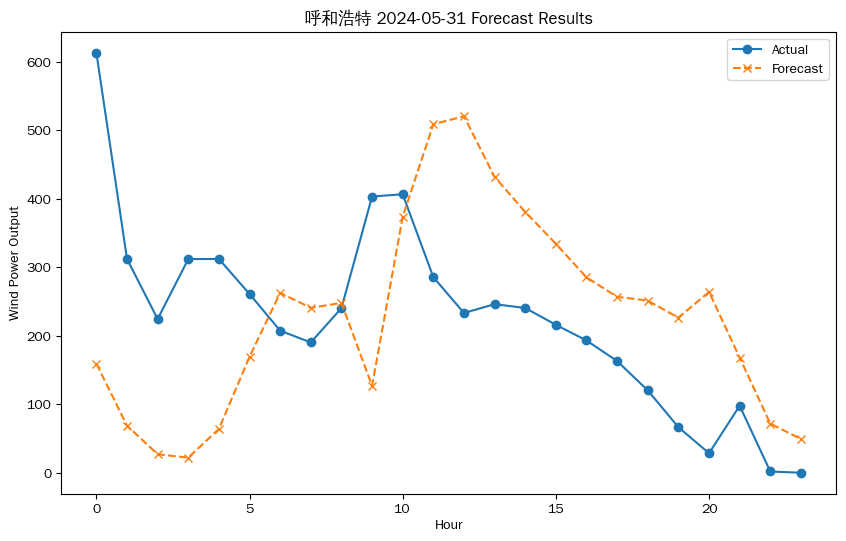

[呼和浩特] RMSE: 190.450, MAE: 158.561, MAPE: 205083593.13%

开始对城市 阿拉善盟 进行测试...
cur city: 阿拉善盟
inside get_data_for_city func


           date_time city_name    value  type
0  1-1-2024 00:15:00      巴彦淖尔  3086.64     3
              date_time city_name   value  type
5952  1-1-2024 00:15:00      阿拉善盟  775.04     3
              date_time   value
5952  1-1-2024 00:15:00  775.04
Index(['t2m', 'ws10m', 'wd10m', 'sp', 'wind_output', 'date'], dtype='object')
                 t2m   ws10m     wd10m          sp  wind_output        date
2024-01-02  270.0522  1.1048  272.2613  85238.3125       764.48  2024-01-02
归一化预览（原地修改）：
                 t2m     ws10m        sp  wind_output        date  wd10m_sin  \
2024-01-02 -0.829561 -1.015792  0.869693     0.514794  2024-01-02  -0.999221   

            wd10m_cos  
2024-01-02   0.039457  
归一化模型已保存到 ../output/wind_data_normalization_models.json
                 t2m     ws10m        sp  wind_output        date  wd10m_sin  \
2024-01-02 -0.829561 -1.015792  0.869

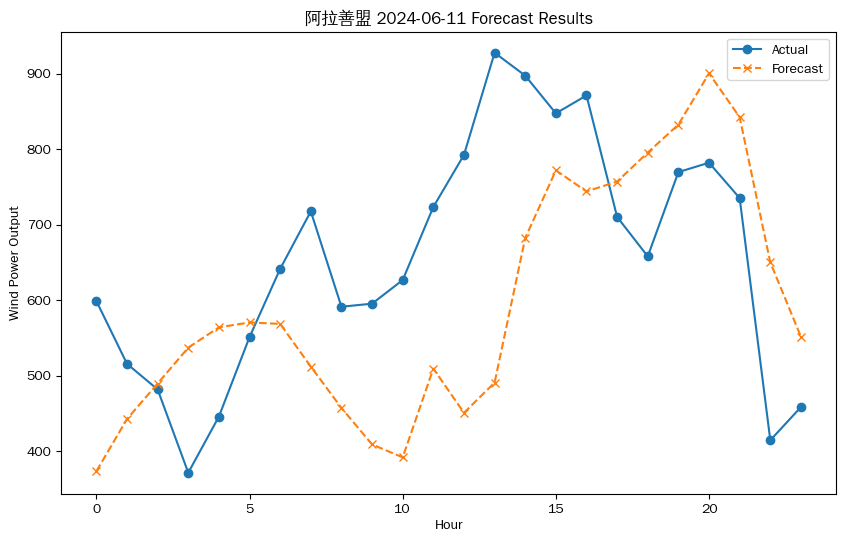

[阿拉善盟] RMSE: 181.517, MAE: 152.401, MAPE: 23.74%

开始对城市 呼和浩特 进行测试...
cur city: 呼和浩特
inside get_data_for_city func


           date_time city_name    value  type
0  1-1-2024 00:15:00      巴彦淖尔  3086.64     3
               date_time city_name   value  type
11904  1-1-2024 00:15:00      呼和浩特  752.32     3
               date_time   value
11904  1-1-2024 00:15:00  752.32
Index(['t2m', 'ws10m', 'wd10m', 'sp', 'wind_output', 'date'], dtype='object')
                 t2m   ws10m    wd10m          sp  wind_output        date
2024-01-02  264.9644  0.4307  52.2255  89793.3125     1343.051  2024-01-02
归一化预览（原地修改）：
                 t2m     ws10m        sp  wind_output        date  wd10m_sin  \
2024-01-02 -0.993252 -1.411099  0.493108     0.741874  2024-01-02   0.790428   

            wd10m_cos  
2024-01-02   0.612555  
归一化模型已保存到 ../output/wind_data_normalization_models.json
                 t2m     ws10m        sp  wind_output        date  wd10m_sin  \
2024-01-02 -0.993252 -1.411099  0.493108  

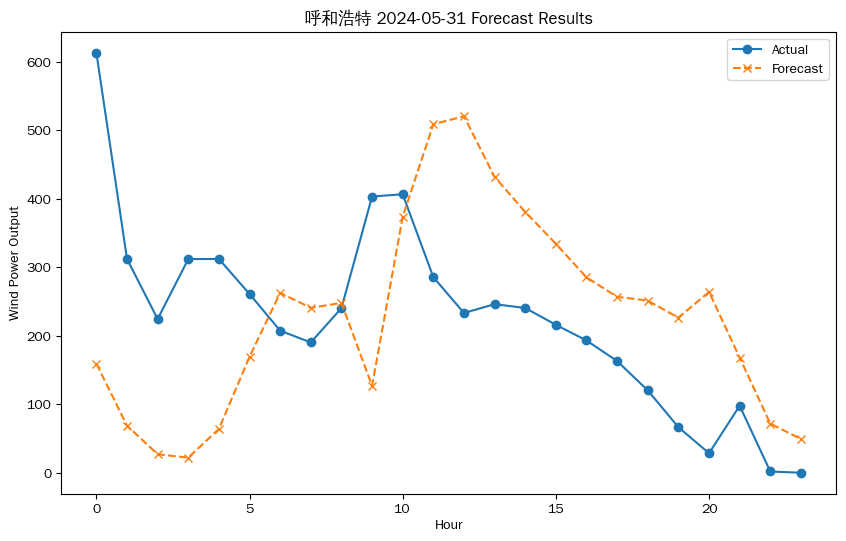

[呼和浩特] RMSE: 190.450, MAE: 158.561, MAPE: 205083593.13%

开始对城市 阿拉善盟 进行测试...
cur city: 阿拉善盟
inside get_data_for_city func


           date_time city_name    value  type
0  1-1-2024 00:15:00      巴彦淖尔  3086.64     3
              date_time city_name   value  type
5952  1-1-2024 00:15:00      阿拉善盟  775.04     3
              date_time   value
5952  1-1-2024 00:15:00  775.04
Index(['t2m', 'ws10m', 'wd10m', 'sp', 'wind_output', 'date'], dtype='object')
                 t2m   ws10m     wd10m          sp  wind_output        date
2024-01-02  270.0522  1.1048  272.2613  85238.3125       764.48  2024-01-02
归一化预览（原地修改）：
                 t2m     ws10m        sp  wind_output        date  wd10m_sin  \
2024-01-02 -0.829561 -1.015792  0.869693     0.514794  2024-01-02  -0.999221   

            wd10m_cos  
2024-01-02   0.039457  
归一化模型已保存到 ../output/wind_data_normalization_models.json
                 t2m     ws10m        sp  wind_output        date  wd10m_sin  \
2024-01-02 -0.829561 -1.015792  0.869

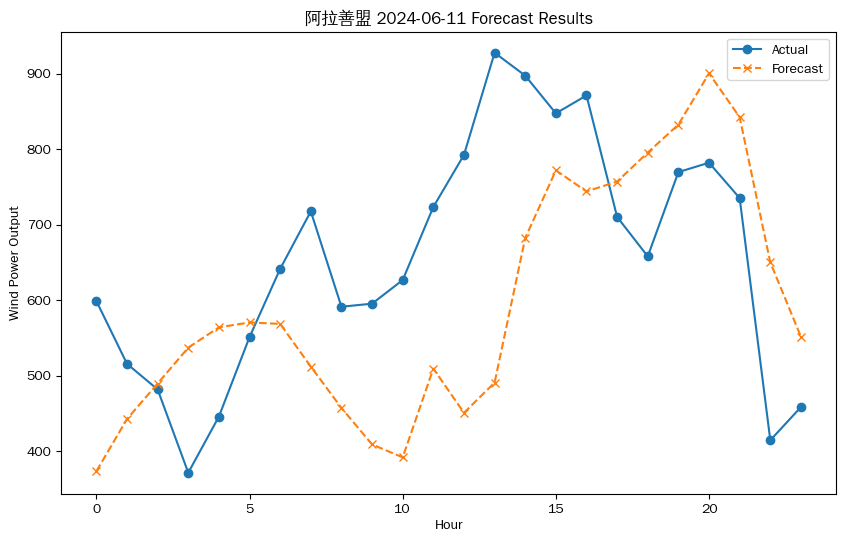

[阿拉善盟] RMSE: 181.517, MAE: 152.401, MAPE: 23.74%

Province Forecast Metrics: RMSE: 245.773, MAE: 192.613, MAPE: 23.36%


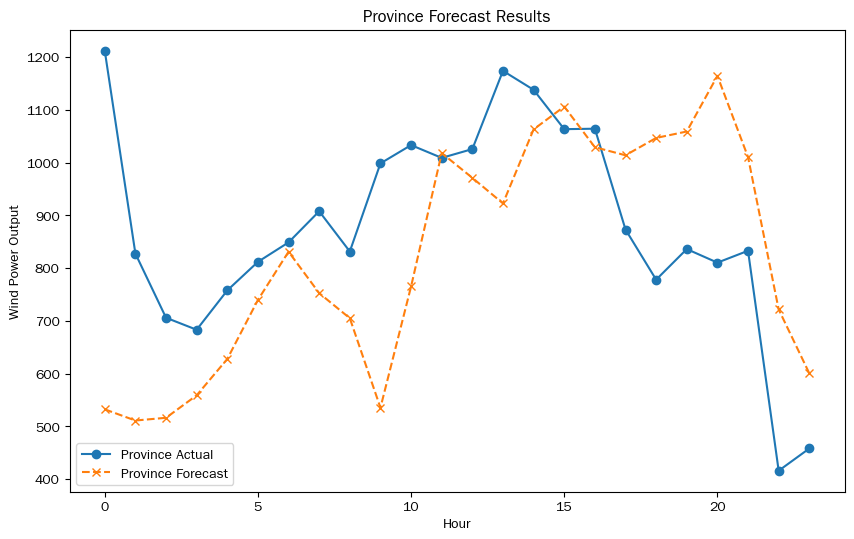


Predicting future 4 days of wind power output for [呼和浩特]...
inside get_data_for_city func


           date_time city_name    value  type
0  1-1-2024 00:15:00      巴彦淖尔  3086.64     3
               date_time city_name   value  type
11904  1-1-2024 00:15:00      呼和浩特  752.32     3
               date_time   value
11904  1-1-2024 00:15:00  752.32
Index(['t2m', 'ws10m', 'wd10m', 'sp', 'wind_output', 'date'], dtype='object')
                 t2m   ws10m    wd10m          sp  wind_output        date
2024-01-02  264.9644  0.4307  52.2255  89793.3125     1343.051  2024-01-02
归一化预览（原地修改）：
                 t2m     ws10m        sp  wind_output        date  wd10m_sin  \
2024-01-02 -0.993252 -1.411099  0.493108     0.741874  2024-01-02   0.790428   

            wd10m_cos  
2024-01-02   0.612555  
归一化模型已保存到 ../output/wind_data_normalization_models.json
参与优化的日期数量: 151
loaded best_params for 呼和浩特: {'w_feature': array([0.94888949, 0.80961146, 0.34524692, 0.13143132, 0.08411753]), 'w_slope': 0.27400

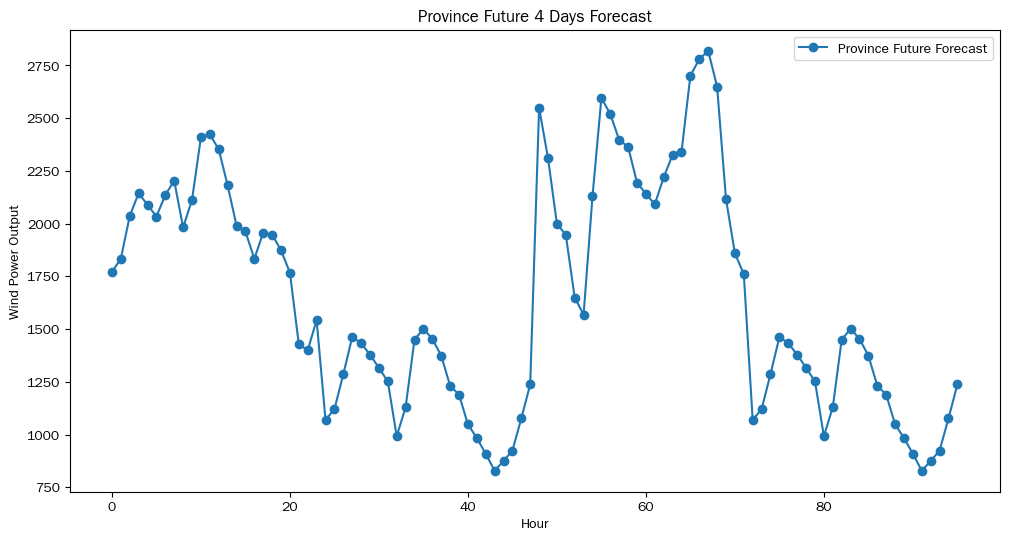

In [14]:
if __name__ == "__main__":
    # train(cities)
    
    # 1. 单城市的某一天预测测试，计算指标和画图
    single_results = test_single_city(cities, day_index=-1)
    
    # 2. 对所有城市同一天的预测结果累加，得到全省预测和指标
    province_actual, province_forecast, province_metrics = predict_province_day(cities, day_index=-1)
    
    # 3. 对未来 n 天，假设你已经准备好未来特征数据
    # 构造示例：对于每个城市用随机数据代替未来特征
    n_days = 4
    future_features_dict = {}
    hours = n_days * 24
    for city in cities:
        future_features = pd.DataFrame({
            't2m': np.random.uniform(-10, 35, hours),          # 温度
            'ws10m': np.random.uniform(0, 10, hours),           # 10米处风速
            'wd10m': np.random.uniform(0, 360, hours),          # 风向（度）
            'sp': np.random.uniform(900, 1050, hours)           # 气压，示例范围
        })
        # 正余弦转换风向，生成新特征
        future_features['wd10m_sin'] = np.sin(np.deg2rad(future_features['wd10m']))
        future_features['wd10m_cos'] = np.cos(np.deg2rad(future_features['wd10m']))
        # 选择并排列与训练一致的特征顺序
        future_features = future_features[['t2m', 'ws10m', 'wd10m_sin', 'wd10m_cos', 'sp']]
        future_features_dict[city] = future_features
    
    province_future_forecast = predict_province_future(cities, future_features_dict, n_days)